# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
from syntheval import SynthEval
from tqdm import tqdm

# User Settings

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    # iteration_list = [3, 5, 7, 10, 15]

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [4]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

df_holdout = df_holdout.dropna().reset_index(drop=True)

In [5]:
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'night_arrival', 'weekend_arrival', 'icu_admission_24h', 'icd_block']
ord_cols = ['consciousness_level','news_score']

cat_ord_cols = cat_cols + ord_cols
print(cat_ord_cols)

['gender', 'ethnicity', 'chief_complaint', 'night_arrival', 'weekend_arrival', 'icu_admission_24h', 'icd_block', 'consciousness_level', 'news_score']


# 2. Funktion

In [6]:
# df_train = df_train.sample(n=1000, random_state=cfg.random_seed).reset_index(drop=True)
# df_synth = df_synth.sample(n=1000, random_state=cfg.random_seed).reset_index(drop=True)
# df_holdout = df_holdout.sample(n=1000, random_state=cfg.random_seed).reset_index(drop=True)

## Erster Test

In [7]:
# results = {}
# mia = SynthEval(real_dataframe=df_train, holdout_dataframe=df_holdout, cat_cols=cat_ord_cols, verbose=False)
# result_mia = mia.evaluate(df_synth, mia={'num_eval_iter': 3})
# print(result_mia)

In [8]:
# df_val = result_mia.melt(
#     id_vars=['metric'], value_vars=['val','n_val'],
#     var_name='class', value_name='score'
# ).replace({'class': {'val':'positive','n_val':'negative'}})

# df_err = result_mia.melt(
#     id_vars=['metric'], value_vars=['err','n_err'],
#     var_name='class', value_name='error'
# ).replace({'class': {'err':'positive','n_err':'negative'}})

# df = pd.merge(df_val, df_err, on=['metric','class'])
# df = df.sort_values(['metric','class'])


# # Pivot to get precision & recall per class
# pivot = df.pivot(index='class', columns='metric')
# p = pivot['score','mia_precision']
# r = pivot['score','mia_recall']
# ep = pivot['error','mia_precision']
# er = pivot['error','mia_recall']

# # Compute F1 and its propagated error
# f1  = 2 * (p * r) / (p + r)
# e_f1 = f1 * np.sqrt((ep/p)**2 + (er/r)**2)

# # Build new rows and append
# f1_df = pd.DataFrame({
#     'metric': ['mia_f1']*len(f1),
#     'class':  f1.index,
#     'score':  f1.values,
#     'error':  e_f1.values
# })
# df = pd.concat([df, f1_df], ignore_index=True)
# print(df)

## Pilot-Studie

In [9]:

# Anzahl Iterationen in der Pilotstudie
iter_list = [3, 5, 10, 20, 30, 40, 50, 75, 100]
results = []

for num_iter in tqdm(iter_list, desc="Pilotstudie"):
    # Init SynthEval (angepasst an deinen Beispielcode)
    mia = SynthEval(
        real_dataframe=df_train,
        holdout_dataframe=df_holdout,
        cat_cols=cat_ord_cols,
        verbose=False
    )
    # Führe MIA aus
    result_mia = mia.evaluate(df_synth, mia={'num_eval_iter': num_iter})
    
    # Auswertung wie von dir vorgegeben
    df_val = result_mia.melt(
        id_vars=['metric'], value_vars=['val','n_val'],
        var_name='class', value_name='score'
    ).replace({'class': {'val':'positive','n_val':'negative'}})

    df_err = result_mia.melt(
        id_vars=['metric'], value_vars=['err','n_err'],
        var_name='class', value_name='error'
    ).replace({'class': {'err':'positive','n_err':'negative'}})

    df = pd.merge(df_val, df_err, on=['metric','class'])
    df = df.sort_values(['metric','class'])

    # Pivot, F1 und Fehler berechnen
    pivot = df.pivot(index='class', columns='metric')
    p = pivot['score','mia_precision']
    r = pivot['score','mia_recall']
    ep = pivot['error','mia_precision']
    er = pivot['error','mia_recall']

    f1  = 2 * (p * r) / (p + r)
    e_f1 = f1 * np.sqrt((ep/p)**2 + (er/r)**2)

    # Neues F1-DF erstellen und anhängen
    f1_df = pd.DataFrame({
        'metric': ['mia_f1']*len(f1),
        'class':  f1.index,
        'score':  f1.values,
        'error':  e_f1.values
    })
    df_full = pd.concat([df, f1_df], ignore_index=True)
    df_full['num_eval_iter'] = num_iter
    results.append(df_full)

# Alle Ergebnisse in ein DataFrame
df_results = pd.concat(results, ignore_index=True)
print(df_results)
if cfg.save_data:
    df_results.to_csv(cfg.results_dir / f"mia_pilot_study_{current_timestamp}.csv", index=False, header=True, decimal=',', sep=';', encoding='utf-8')

Pilotstudie: 100%|██████████| 9/9 [05:04<00:00, 33.82s/it]

           metric     class     score     error  num_eval_iter
0   mia_precision  negative  0.995907  0.001979              3
1   mia_precision  positive  0.502046  0.001979              3
2      mia_recall  negative  0.873488  0.001401              3
3      mia_recall  positive  0.126512  0.001401              3
4          mia_f1  negative  0.930689  0.002377              3
5          mia_f1  positive  0.202097  0.002375              3
6   mia_precision  negative  0.998155  0.005149              5
7   mia_precision  positive  0.500923  0.005149              5
8      mia_recall  negative  0.874292  0.002690              5
9      mia_recall  positive  0.125708  0.002690              5
10         mia_f1  negative  0.932127  0.005599              5
11         mia_f1  positive  0.200979  0.004771              5
12  mia_precision  negative  0.999837  0.002839             10
13  mia_precision  positive  0.500081  0.002839             10
14     mia_recall  negative  0.872136  0.001578        

In [9]:
df_results = pd.read_csv(cfg.results_dir / f"mia_pilot_study_20250518_075002.csv", sep=';', decimal=',', encoding='utf-8')

Abbildung gespeichert unter: figures\MIA_Pilot-Studie_20250601_164544.tiff


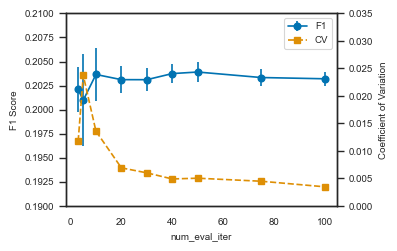

In [14]:
# CV berechnen: error / score
df_results['cv'] = df_results['error'] / df_results['score']

# Nur F1-Werte (z.B. für positive Klasse) auswählen
df_f1_pos = df_results[(df_results['metric'] == 'mia_f1') & (df_results['class'] == 'positive')]
df_f1_neg = df_results[(df_results['metric'] == 'mia_f1') & (df_results['class'] == 'negative')]

cb_colors = sns.color_palette("colorblind")[:2]

# Plot F1, Fehler und CV für positive Klasse
fig, ax1 = plt.subplots(figsize=(3.5,2.5))

ax1.errorbar(df_f1_pos['num_eval_iter'], df_f1_pos['score'], yerr=df_f1_pos['error'],
             fmt='o-', label='F1', color=cb_colors[0])
ax1.set_xlabel('num_eval_iter')
ax1.set_ylabel('F1 Score')
ax1.set_ylim(0.19, 0.21)  # Setze y-Achse für F1 Score
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(df_f1_pos['num_eval_iter'], df_f1_pos['cv'], 's--', label='CV', color=cb_colors[1])
ax2.set_ylabel('Coefficient of Variation')
ax2.set_ylim(0, 0.035)  # Setze y-Achse für CV
ax2.tick_params(axis='y')

# fig.suptitle('Konvergenz & CV der F1-Metrik (positive)')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, fontsize=7)
if cfg.save_data:
    fname = f'MIA_Pilot-Studie_{current_timestamp}.tiff'
    fullpath = cfg.figures_dir / fname
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()

# 3. Visualisierung

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Wissenschaftlichen Look einstellen
sns.set_theme(context='paper', style='whitegrid')

df_val = result_mia.melt(
    id_vars=['metric'], value_vars=['val','n_val'],
    var_name='class', value_name='score'
).replace({'class': {'val':'positive','n_val':'negative'}})

df_err = result_mia.melt(
    id_vars=['metric'], value_vars=['err','n_err'],
    var_name='class', value_name='error'
).replace({'class': {'err':'positive','n_err':'negative'}})

df = pd.merge(df_val, df_err, on=['metric','class'])
df = df.sort_values(['metric','class'])



In [ ]:
print(df)

          metric     class     score     error
3  mia_precision  negative  0.963389  0.030301
1  mia_precision  positive  0.518306  0.030301
2     mia_recall  negative  0.755200  0.014500
0     mia_recall  positive  0.244800  0.014500


### Macro-F1-Score

In [39]:
import numpy as np
# Pivot to get precision & recall per class
pivot = df.pivot(index='class', columns='metric')
p = pivot['score','mia_precision']
r = pivot['score','mia_recall']
ep = pivot['error','mia_precision']
er = pivot['error','mia_recall']

# Compute F1 and its propagated error
f1  = 2 * (p * r) / (p + r)
e_f1 = f1 * np.sqrt((ep/p)**2 + (er/r)**2)

# Build new rows and append
f1_df = pd.DataFrame({
    'metric': ['mia_f1']*len(f1),
    'class':  f1.index,
    'score':  f1.values,
    'error':  e_f1.values
})
df = pd.concat([df, f1_df], ignore_index=True)
print(df)

          metric     class     score     error
0  mia_precision  negative  0.963389  0.030301
1  mia_precision  positive  0.518306  0.030301
2     mia_recall  negative  0.755200  0.014500
3     mia_recall  positive  0.244800  0.014500
4         mia_f1  negative  0.846684  0.031200
5         mia_f1  positive  0.332539  0.027675


In [43]:
df_plot = df[df['class']=='positive'].copy()
print(df_plot)

          metric     class     score     error
1  mia_precision  positive  0.518306  0.030301
3     mia_recall  positive  0.244800  0.014500
5         mia_f1  positive  0.332539  0.027675


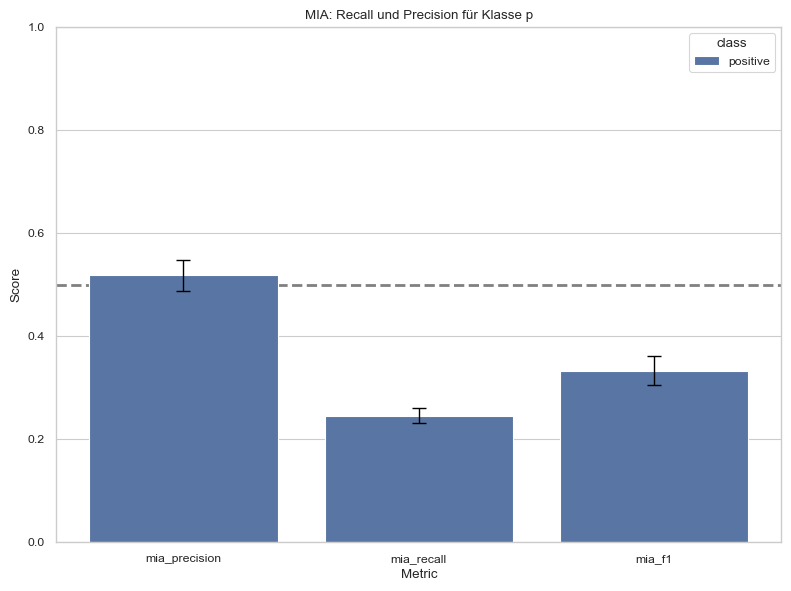

In [47]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_plot, x='metric', y='score', hue='class', errorbar=None)

# Fehlerbalken hinzufügen (synchron mit df['error'])
for bar, err in zip(ax.patches, df_plot['error']):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.errorbar(x, y, yerr=err, fmt='none', capsize=5, color='black', elinewidth=1, capthick=1)

# --- 5a) Horizontale Threshold-Linie einzeichnen ---
ax.axhline(
    y=0.5,
    color='grey',        # Farbe der Linie
    linestyle='--',      # gestrichelte Linie
    linewidth=2,         # Linienstärke
    label='Threshold',
    zorder=0
)

plt.ylabel('Score')
plt.xlabel('Metric')
plt.title('MIA: Recall und Precision für Klasse p')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Interpretation
✅ Nein, n_val und n_err (negative) stehen nicht direkt für „Nicht-Mitglied-Test“.
→ Sie sind komplementäre Werte zu val (also z.B. 1 - recall oder 1 - 2*|0.5 - precision|), um die „Abweichung von idealer Privacy“ darzustellen.
👉 Sie dienen der Darstellung der „Nicht-Privacy“ oder „Fehlerrate“:
- n_val ≈ 1 → gute Privacy (Angreifer kann wenig)
- n_val ≈ 0 → schwache Privacy (Angreifer kann viel)
➡️ Also eher eine Interpretationshilfe, kein expliziter Test auf „nicht enthalten“.


✅ In der Literatur gibt es keinen festen universellen Schwellenwert für val (z.B. Precision, Recall oder F1 bei MIA).
➡️ Oft wird ein Wert deutlich über Zufallsniveau (~0.5) als Hinweis auf Privacy-Risiko betrachtet (vgl. Shokri et al., 2017).
📚 Referenz:
Shokri, R., Stronati, M., Song, C., & Shmatikov, V. (2017). Membership Inference Attacks Against Machine Learning Models. IEEE S&P.
Dort gilt: „significantly better than random guessing“ → Risiko.
Typisch: >0.6–0.7 als kritisch, aber abhängig von Kontext & Use-Case.


## Precision: Anteil korrekter „Mitglied“-Vorhersagen unter allen vorhergesagten Mitgliedern
- Precision ≈ 0: Vorhersagen sind fast alle falsch → Angreifer rät schlecht.
- Precision ≈ 0.5: Vorhersagen sind wie Zufall → keine verwertbare Information.
- Precision ≈ 1: Vorhersagen sind alle korrekt → Angreifer kann Mitglieder perfekt erkennen → hohes Privacy-Risiko.


## Recall: Anteil der tatsächlichen Mitglieder, die korrekt erkannt wurden
- Recall ≈ 0: Angreifer erkennt fast kein Mitglied → sehr geringe Leakage.
- Recall ≈ 0.5: Angreifer erkennt 50% der Mitglieder → besser als Zufall, mildes Risiko.
- Recall ≈ 1: Angreifer erkennt alle Mitglieder → sehr hohes Risiko.


## Macro-F1: Harmonie zwischen Precision und Recall (balancierter Mittelwert)
- Macro-F1 ≈ 0: keine sinnvolle Erkennung (Precision & Recall schlecht).
- Macro-F1 ≈ 0.5: durchschnittliche Performance, nahe Zufall → akzeptabel.
- Macro-F1 ≈ 1: perfekte Erkennung → hohes Risiko.

